# 参数化注意力

In [20]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
from lib.d2l_torch import Module, HyperParameters, Trainer, DataModule, plot, show_heatmaps


In [21]:
def plot_kernel_reg(data, y_hat):
    """绘制图像, 将原始数据集和预测的绘制在一起

    Args:
        y_hat (_type_): 预测得到的 y 值
    """
    plot(
        data.x_val, 
        [data.y_val, y_hat.detach().numpy()], 'x', 'y', legend=['Truth', 'Pred'],
        xlim=[0, 5], ylim=[-1, 5]
    )
    plt.plot(data.x_train, data.y_train, 'o', alpha=0.5)

## 数据集生成

In [12]:
class NonlinearData(DataModule):
    """生成数据集,
     y = 2*sin(x) + x^0.8 + epsilon
    """
    def __init__(self, n, batch_size):
        self.save_hyperparameters()
        f = lambda x: 2 * torch.sin(x) + x**0.8
        self.x_train, _ = torch.sort(torch.rand(n) * 5)
        self.y_train = f(self.x_train) + torch.randn(n) # 用于训练的 label
        self.x_val = torch.arange(0, 5, 5.0/n)
        self.y_val = f(self.x_val) # 用于测试的 label

    def get_dataloader(self, train):
        arrays = (self.x_train, self.y_train) if train else (self.x_val, self.y_val)
        return self.get_tensorloader(arrays, train)

In [13]:
n = 50
data = NonlinearData(n, batch_size=10)

## 初始化模型

In [14]:
def diff(queries, keys):
    """计算 query 和 key 的距离
    """
    return queries.reshape((-1, 1)) - keys.reshape((1, -1))

def attention_pool(query_key_diffs, values):
    attention_weights = F.softmax(- query_key_diffs**2 / 2, dim=1) # 计算权重
    return torch.matmul(attention_weights, values), attention_weights # 权重和 value 相乘


In [15]:
class SGD(HyperParameters):
    """Defined in :numref:`sec_linear_scratch`"""
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        """对 params 进行更新
        """
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [16]:
class NWKernelRegression(Module):
    def __init__(self, keys, values, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.ones(1, requires_grad=True) # w 权重

    def forward(self, queries):
        y_hat, self.attention_weights = attention_pool(
            diff(queries, self.keys) * self.w, self.values)
        return y_hat

    def loss(self, y_hat, y):
        l = (y_hat.reshape(-1) - y.reshape(-1)) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w], self.lr)

## 开始训练

In [17]:
model = NWKernelRegression(data.x_train, data.y_train, lr=0.1) # 初始化模型
model.board.display = False
trainer = Trainer(max_epochs=100)
trainer.fit(model, data)

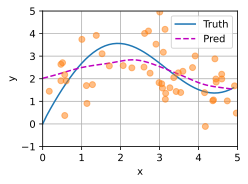

In [22]:
plot_kernel_reg(
    data=data, 
    y_hat=model.forward(data.x_val)
)

In [23]:
show_heatmaps(
    matrices=[[model.attention_weights]],
    xlabel='Sorted training inputs',
    ylabel='Sorted validation inputs'
)

TypeError: show_heatmaps() missing 2 required positional arguments: 'xlabel' and 'ylabel'